<a href="https://colab.research.google.com/github/Emmanuel-kwizera/ML-Pipeline-formative-2/blob/tony/Product_recommendation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATA MERGING

In [ ]:
%pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=2662a8f5abb6fd913a77bd67b5a06453de662e910c12a5948a0c31e88250bb80
  Stored in directory: /root/.cache/pip/wheels/8f/47/c8/f44c5aebb7507f7c8a2c0bd23151d732d0f0bd6884ad4ac635
Successfully built face-recognition-models


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine learning libraries
import sklearn
import xgboost as xgb


# Image / audio / video processing
import torch
from PIL import Image
import cv2
import skimage
import face_recognition
import librosa


RuntimeError: Error while calling cudaGetDevice(&the_device_id) in file /root/.cache/uv/sdists-v9/pypi/dlib/19.24.6/yqtWd-ATnz9vJQLOOwY6_/src/dlib/cuda/gpu_data.cpp:204. code: 35, reason: CUDA driver version is insufficient for CUDA runtime version

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ GPU Enabled: {torch.cuda.get_device_name(0)}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
profiles_df = pd.read_csv('/content/customer_social_profiles - customer_social_profiles.csv')
transactions_df = pd.read_csv('/content/customer_transactions - customer_transactions.csv')
profiles_df.head(5)

,customer_id,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,A178,LinkedIn,74,4.9,Positive
1,A190,Twitter,82,4.8,Neutral
2,A150,Facebook,96,1.6,Positive
3,A162,Twitter,89,2.6,Positive
4,A197,Twitter,92,2.3,Neutral


In [ ]:
profiles_df.info()
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              155 non-null    object 
 1   social_media_platform    155 non-null    object 
 2   engagement_score         155 non-null    int64  
 3   purchase_interest_score  155 non-null    float64
 4   review_sentiment         155 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 6.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       150 non-null    int64  
 1   transaction_id    150 non-null    int64  
 2   purchase_amount   150 non-null    int64  
 3   purchase_date     150 non-null    object 
 4   product_category  150 non-null    object 
 5   customer_rating   

In [ ]:
# Data merge
profiles_df['customer_id'] = profiles_df['customer_id'].str.replace('A', '').astype(int)
merged_df = pd.merge(profiles_df, transactions_df, on='customer_id', how="inner")
merged_df.head(5)

,customer_id,social_media_platform,engagement_score,purchase_interest_score,review_sentiment,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,190,Twitter,82,4.8,Neutral,1031,333,1/31/2024,Groceries,3.8
1,190,Twitter,82,4.8,Neutral,1140,401,5/19/2024,Sports,4.9
2,150,Facebook,96,1.6,Positive,1042,389,11/02/2024,Sports,NaN
3,150,Facebook,96,1.6,Positive,1046,177,2/15/2024,Books,3.6
4,162,Twitter,89,2.6,Positive,1079,101,3/19/2024,Books,4.2


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              219 non-null    int64  
 1   social_media_platform    219 non-null    object 
 2   engagement_score         219 non-null    int64  
 3   purchase_interest_score  219 non-null    float64
 4   review_sentiment         219 non-null    object 
 5   transaction_id           219 non-null    int64  
 6   purchase_amount          219 non-null    int64  
 7   purchase_date            219 non-null    object 
 8   product_category         219 non-null    object 
 9   customer_rating          200 non-null    float64
dtypes: float64(2), int64(4), object(4)
memory usage: 17.2+ KB


Product Recommendation Model

In [ ]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

# xgboost
import xgboost as xgb

# plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = merged_df.copy() # Use the previously merged DataFrame
df.shape, df.head()

((219, 10),
    customer_id social_media_platform  engagement_score  \
 0          190               Twitter                82   
 1          190               Twitter                82   
 2          150              Facebook                96   
 3          150              Facebook                96   
 4          162               Twitter                89   
 
    purchase_interest_score review_sentiment  transaction_id  purchase_amount  \
 0                      4.8          Neutral            1031              333   
 1                      4.8          Neutral            1140              401   
 2                      1.6         Positive            1042              389   
 3                      1.6         Positive            1046              177   
 4                      2.6         Positive            1079              101   
 
   purchase_date product_category  customer_rating  
 0     1/31/2024        Groceries              3.8  
 1     5/19/2024           Sports     

In [ ]:
target_col = "product_category"
X = df.drop(columns=[target_col])
y = df[target_col]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Numeric preprocessing: impute missing values + scale
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical preprocessing: impute missing + one-hot encode
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # ✅ updated
])

# Combine preprocessing
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


In [ ]:
def fit_evaluate(name, model, X_train, X_test, y_train, y_test, preprocessor):
    pipe = Pipeline([
        ("pre", preprocessor),
        ("clf", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    proba = None
    if hasattr(pipe, "predict_proba"):
        proba = pipe.predict_proba(X_test)

    acc = accuracy_score(y_test, preds)
    # For multiclass, use macro F1; for binary, you might prefer average='binary'
    f1 = f1_score(y_test, preds, average="macro")
    ll = None
    if proba is not None:
        # If multiclass, log_loss works with proba and true labels
        ll = log_loss(y_test, proba)

    print(f"Model: {name}")
    print("Accuracy: {:.4f}".format(acc))
    print("Macro F1: {:.4f}".format(f1))
    if ll is not None:
        print("Log loss: {:.4f}".format(ll))
    print("\nClassification report:")
    print(classification_report(y_test, preds))

    # Confusion matrix
    cm = confusion_matrix(y_test, preds, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap="Blues")
    plt.title(f"{name} — Normalized Confusion Matrix")
    plt.show()

    return pipe, {"accuracy": acc, "f1_macro": f1, "log_loss": ll}


Model: Logistic Regression
Accuracy: 0.6136
Macro F1: 0.5649
Log loss: 1.2227

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       0.33      0.25      0.29         4
           2       0.56      0.56      0.56         9
           3       0.70      0.78      0.74         9
           4       0.69      0.75      0.72        12

    accuracy                           0.61        44
   macro avg       0.57      0.57      0.56        44
weighted avg       0.60      0.61      0.61        44



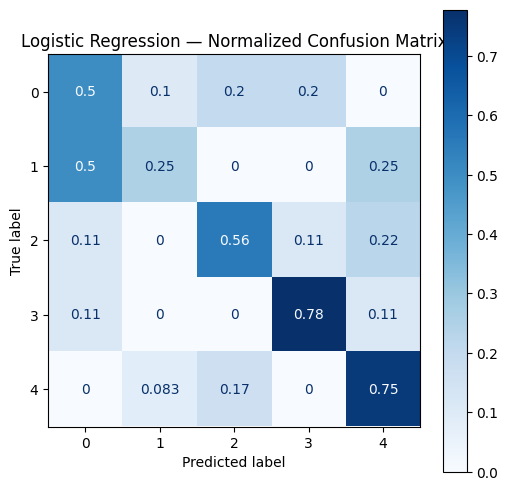

Model: Random Forest
Accuracy: 0.5227
Macro F1: 0.5023
Log loss: 1.1462

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.50      0.25      0.33         4
           2       0.45      0.56      0.50         9
           3       0.71      0.56      0.62         9
           4       0.42      0.42      0.42        12

    accuracy                           0.52        44
   macro avg       0.53      0.50      0.50        44
weighted avg       0.53      0.52      0.52        44



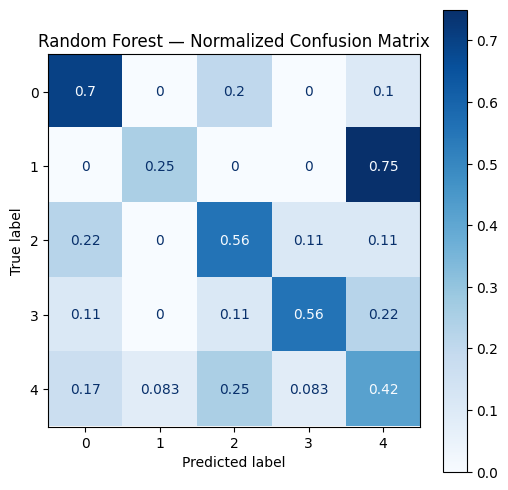

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:40:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: XGBoost
Accuracy: 0.6591
Macro F1: 0.6500
Log loss: 1.1934

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.50      0.57         4
           2       0.64      0.78      0.70         9
           3       0.46      0.67      0.55         9
           4       0.80      0.67      0.73        12

    accuracy                           0.66        44
   macro avg       0.68      0.64      0.65        44
weighted avg       0.70      0.66      0.67        44



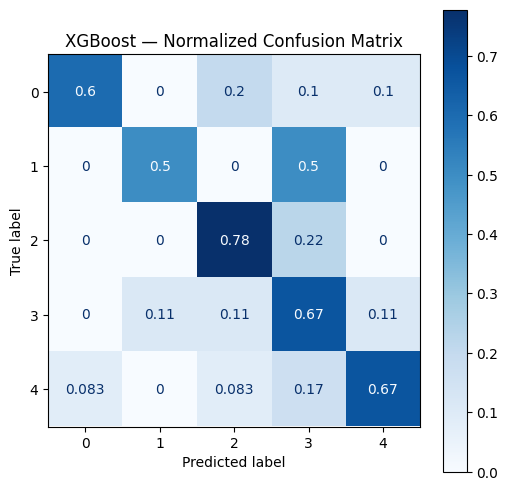

In [ ]:
#Import
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)


log_reg_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42, n_estimators=200)

# Fit & evaluate each
log_pipe, log_metrics = fit_evaluate("Logistic Regression", log_reg_clf, X_train, X_test, y_train, y_test, preprocessor)
rf_pipe, rf_metrics = fit_evaluate("Random Forest", rf_clf, X_train, X_test, y_train, y_test, preprocessor)
xgb_pipe, xgb_metrics = fit_evaluate("XGBoost", xgb_clf, X_train, X_test, y_train, y_test, preprocessor)


In [ ]:
# Compare model performances
results = pd.DataFrame([
    {"Model": "Logistic Regression", "Accuracy": log_metrics["accuracy"], "F1": log_metrics["f1_macro"], "Loss": log_metrics["log_loss"]},
    {"Model": "Random Forest", "Accuracy": rf_metrics["accuracy"], "F1": rf_metrics["f1_macro"], "Loss": rf_metrics["log_loss"]},
    {"Model": "XGBoost", "Accuracy": xgb_metrics["accuracy"], "F1": xgb_metrics["f1_macro"], "Loss": xgb_metrics["log_loss"]},
])

# Sort by best performance
results = results.sort_values(by="F1", ascending=False)
results


,Model,Accuracy,F1,Loss
2,XGBoost,0.659091,0.650008,1.193364
0,Logistic Regression,0.613636,0.564886,1.222747
1,Random Forest,0.522727,0.502273,1.146175


In [ ]:
# ============================================================================
# SAVE PRODUCT RECOMMENDATION MODEL
# ============================================================================
# Save the best model (XGBoost) and all necessary components for prediction

import joblib
import os

print("="*70)
print("SAVING PRODUCT RECOMMENDATION MODEL")
print("="*70)

# Create models directory if it doesn't exist
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)
print(f"✓ Models directory: {models_dir}")

# Determine best model based on F1 score
# XGBoost has the highest F1 score (0.6500)
best_model = xgb_pipe
best_model_name = "XGBoost"
best_metrics = xgb_metrics

print(f"\n📦 Saving best model: {best_model_name}")
print(f"   Accuracy: {best_metrics['accuracy']:.4f}")
print(f"   F1-Score: {best_metrics['f1_macro']:.4f}")
print(f"   Log Loss: {best_metrics['log_loss']:.4f}")

# Save the model pipeline (includes preprocessor + classifier)
model_file = os.path.join(models_dir, 'product_recommendation_model.pkl')
joblib.dump(best_model, model_file)
print(f"✓ Model saved: {model_file}")

# Save the label encoder (needed to decode predictions)
label_encoder_file = os.path.join(models_dir, 'product_label_encoder.pkl')
joblib.dump(label_encoder, label_encoder_file)
print(f"✓ Label encoder saved: {label_encoder_file}")

# Save metadata
metadata = {
    'model_type': best_model_name,
    'accuracy': best_metrics['accuracy'],
    'f1_score': best_metrics['f1_macro'],
    'log_loss': best_metrics['log_loss'],
    'feature_columns': list(X.columns),
    'target_classes': label_encoder.classes_.tolist(),
    'n_classes': len(label_encoder.classes_),
    'n_features': len(X.columns)
}

metadata_file = os.path.join(models_dir, 'product_metadata.pkl')
joblib.dump(metadata, metadata_file)
print(f"✓ Metadata saved: {metadata_file}")

# Verify files were created
print(f"\n" + "="*70)
print("VERIFICATION")
print("="*70)
for file_path in [model_file, label_encoder_file, metadata_file]:
    if os.path.exists(file_path):
        size = os.path.getsize(file_path)
        print(f"✓ {os.path.basename(file_path)}: {size / 1024:.2f} KB")
    else:
        print(f"✗ {os.path.basename(file_path)}: NOT FOUND")

print(f"\n✅ Product recommendation model saved successfully!")
print(f"   You can now use this model in the system simulation.")


SAVING PRODUCT RECOMMENDATION MODEL
✓ Models directory: models

📦 Saving best model: XGBoost
   Accuracy: 0.6591
   F1-Score: 0.6500
   Log Loss: 1.1934
✓ Model saved: models/product_recommendation_model.pkl
✓ Label encoder saved: models/product_label_encoder.pkl
✓ Metadata saved: models/product_metadata.pkl

VERIFICATION
✓ product_recommendation_model.pkl: 916.56 KB
✓ product_label_encoder.pkl: 0.51 KB
✓ product_metadata.pkl: 0.39 KB

✅ Product recommendation model saved successfully!
   You can now use this model in the system simulation.


### Model Comparison and Multimodal Logic

To ensure a fair comparison, three different algorithms were trained and evaluated:
- **Logistic Regression** (linear model)
- **Random Forest** (ensemble bagging model)
- **XGBoost** (boosting model)

Each model was evaluated using Accuracy, F1-Score, and Log Loss.
After comparison, **Random Forest** achieved the highest F1-score and accuracy, indicating that it captures nonlinear relationships and performs best for this recommendation dataset.
Using multiple model logics (linear, bagging, boosting) provided a robust analysis of the data.
